In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from HMM import unsupervised_HMM
from HMM import supervised_HMM
from HMM_helper import sample_sentence
from dtaidistance import dtw
from dtaidistance import clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, leaves_list
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering


In [2]:
import git
import sys
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [3]:
def makeHMMUnSupData(Input, colname, fipsname):
    #Takes input dataframe, and gives out HMM format of data, a list of lists 
    #of the colname value, each list in the set represents one fips code.
    Output = []
    for fips in Input[fipsname].unique():
        temp = list(Input[Input[fipsname] == fips][colname])
        Output.append(temp)
    return Output

In [4]:
def makeHMMmap(Output):
    #Takes in output of makeHMMUnSupData and transforms data into list from 0 to D-1, where D is the number of unique
    #values of the output
    #Unqiue values in the input
    UniqueVals = np.array(list(set(x for l in Output for x in l)))
    UniqueVals = np.sort(UniqueVals)
    HMMOutput = []
    templs = []
    Map = {}
    RMap = {}
    for x in range(len(UniqueVals)):
        Map[int(UniqueVals[x])] = x
        RMap[x] = int(UniqueVals[x])
    for ls in Output:
        for val in ls:
            templs.append(Map[val])
        HMMOutput.append(templs)
        templs = []
    return [Map,RMap,HMMOutput]

In [5]:
def makeHMMSupData(UnSupData):
    #Takes list of lists of time series data from makeHMMUnSupData and makes it into data with X and Y
    X = []
    Y = []
    tempX = []
    tempY = []
    for ls in UnSupData:
        lenls = len(ls)
        for n in range(lenls):            
            if n == 0:
                tempX.append(ls[n])
            elif n == lenls - 1:
                tempY.append(ls[n])
            else:
                tempX.append(ls[n])
                tempY.append(ls[n])
        if len(tempX) != 0 and len(tempY) != 0:
            X.append(tempX)
            Y.append(tempY)
        tempX = []
        tempY = []   
    return [X,Y]

In [6]:
#Cumulative Death Data
NYT_tot = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties.csv")
NYT_tot = NYT_tot.drop(columns=['county','state']).sort_values(['fips','date']).reset_index(drop=True)
NYT_tot = NYT_tot.dropna(subset=['fips'])
NYT_tot['fips'] = NYT_tot.fips.astype(int)
NYT_tot['date'] = pd.to_datetime(NYT_tot['date'])
NYT_tot['id'] = NYT_tot.fips.astype(str).str.cat(NYT_tot.date.astype(str), sep=', ')
#Making new parameter for deathrate
NYT_tot['deathrate'] = NYT_tot['deaths']/NYT_tot['cases']
NYT_tot = NYT_tot.fillna(0)
#multiplying death rate by 1000 to give integer state values
NYT_tot['deathstate'] = NYT_tot['deathrate']*1000
NYT_tot['deathstate'] = NYT_tot['deathstate'].astype(int)

In [7]:
#Differenced Daily Death Data
NYT_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
NYT_daily = NYT_daily.drop(columns=['county','state']).sort_values(['fips','date']).reset_index(drop=True)
NYT_daily['fips'] = NYT_daily.fips.astype(int)
NYT_daily['date'] = pd.to_datetime(NYT_daily['date'])
NYT_daily['id'] = NYT_daily.fips.astype(str).str.cat(NYT_daily.date.astype(str), sep=', ')
FirstDay = min(NYT_daily.date.unique())
LastDay = max(NYT_daily.date.unique())

In [8]:
#Making a time-warping of NYT daily data, so each county has a value at the starting day of 2020-01-21
# and then a final value at the most recent day
NYT_daily_Warp = NYT_daily
for fips in NYT_daily.fips.unique():
    rows = NYT_daily[NYT_daily['fips'] == fips]
    #adding in the first day values
    if FirstDay not in rows.date.unique():
        NYT_daily_Warp = NYT_daily_Warp.append({'fips': fips, 'date': pd.to_datetime('2020-01-21'), \
                               'cases': 0, 'deaths' : 0, 'id' : str(fips) + ', 2020-01-21'}, ignore_index=True)
    #making sure each entry has the final day values
    if LastDay not in rows.date.unique():
        NYT_daily_Warp = NYT_daily_Warp[NYT_daily_Warp['fips'] != fips]
NYT_daily_Warp = NYT_daily_Warp.sort_values(['fips','date']).reset_index(drop=True)

In [9]:
NYT_daily_Warp_Death = makeHMMUnSupData(NYT_daily_Warp, 'deaths', 'fips')

In [10]:
#This is a list of all the counties and dates
County_List = list(NYT_daily.fips.unique())
Date_List = list(NYT_daily.date.unique())
#This creates a base dataframe that contains all pairs of FIPS codes with the valid dates given in Air_Qual
CL, DL = pd.core.reshape.util.cartesian_product([County_List, Date_List])
BaseFrame = pd.DataFrame(dict(fips=CL, date=DL)).sort_values(['fips','date']).reset_index(drop=True)
BaseFrame['id'] = BaseFrame.fips.astype(str).str.cat(BaseFrame.date.astype(str), sep=', ')

In [11]:
#Making frame of all deaths at all dates to properly do DTW clustering
NYT_daily_Filled = BaseFrame.join(NYT_daily.set_index('id'), on='id', how='outer', lsuffix=''\
               ,rsuffix='_x').sort_values(['fips','date']).drop(columns=['fips_x','date_x']).fillna(0).drop_duplicates(subset=['fips','date']).reset_index(drop=True)

In [12]:
#List of lists of daily death count for each county, starting 1/23/20, ending most recent date.
NYT_daily_Death_Filled = makeHMMUnSupData(NYT_daily_Filled, 'deaths', 'fips')

In [13]:
#JHU Data
JHU_tot = pd.read_csv(f"{homedir}/data/us/covid/JHU_daily_US.csv").sort_values(['FIPS','Date'])
FIPSlist = JHU_tot.FIPS.unique()
Datelist = JHU_tot.Date.unique()
Datepair = [Datelist[0],Datelist[-1]]

In [14]:
#Getting rid of unneded fips code in the list of total codes
for fips in FIPSlist:
    rows = JHU_tot[JHU_tot['FIPS'] == fips]
    datelist = rows.Date.unique()
    datepair = [datelist[0],datelist[-1]]
    if np.array_equal(Datepair,datepair) != True:
        JHU_tot = JHU_tot.drop(list(JHU_tot[JHU_tot['FIPS'] == fips].index))
JHU_tot = JHU_tot.sort_values(['FIPS','Date']).reset_index(drop=True)

In [15]:
def monotonicCol(Data, colname):
    #Takes a column that should have monotonically increasing data for a column (number of deaths)
    #and adjusts the column to ensure this property, iterating backwards through each fips code's entries
    ls = []
    tempvals = []
    for fips in Data.FIPS.unique():
        vals = list(Data[Data['FIPS'] == fips][colname])
        flag = True
        for val in reversed(vals):
            if flag:
                flag = False
                maxval = val
                tempvals.append(maxval)
            else:
                if val > maxval:
                    tempvals.append(maxval)
                else:
                    maxval = val
                    tempvals.append(val)
        ls.extend(reversed(tempvals))
        tempvals = []
    return ls

In [16]:
d = {'FIPS': JHU_tot['FIPS'], 'Date' : JHU_tot['Date'], 'Confirmed' : monotonicCol(JHU_tot,'Confirmed'),\
       'Deaths' : monotonicCol(JHU_tot,'Deaths'),'Active' : monotonicCol(JHU_tot,'Active'), \
        'Recovered' : monotonicCol(JHU_tot,'Recovered')}
#Monotonically increaasing transformation of JHU_tot
JHU_mono = pd.DataFrame(data=d)

In [17]:
def cumtoDaily(Data, colname):
    #Takes cumulative column data and turns the data into daily changes 
    ls = []
    column = Data[colname]
    for fips in Data.FIPS.unique():
        ls.extend(list(Data[Data['FIPS'] == fips][colname].diff().fillna(0)))
    return ls

In [18]:
d = {'FIPS': JHU_mono['FIPS'], 'Date' : JHU_mono['Date'], 'Confirmed' : cumtoDaily(JHU_mono,'Confirmed'),\
       'Deaths' : cumtoDaily(JHU_mono,'Deaths'),'Active' : cumtoDaily(JHU_mono,'Active'), \
        'Recovered' : cumtoDaily(JHU_mono,'Recovered')}
#Daily changing data based on monotonically transformed data
JHU_daily = pd.DataFrame(data=d)

In [19]:
#List of lists of daily death count for each county, starting 3/23/20, ending most recent date.
JHU_daily_death = makeHMMUnSupData(JHU_daily, 'Deaths', 'FIPS')

In [20]:
#Our three types of death lists for DTW clusterings
NYT_daily_Warp_Death
NYT_daily_Death_Filled
JHU_daily_death

print(len(NYT_daily_Warp_Death))
print(np.mean([len(a) for a in NYT_daily_Warp_Death]))
print(np.mean([sum(a) for a in NYT_daily_Warp_Death]))
print(np.mean([np.mean(a) for a in NYT_daily_Warp_Death]))

print(len(NYT_daily_Death_Filled))
print(np.mean([len(a) for a in NYT_daily_Death_Filled]))
print(np.mean([sum(a) for a in NYT_daily_Death_Filled]))
print(np.mean([np.mean(a) for a in NYT_daily_Death_Filled]))

print(len(JHU_daily_death))
print(np.mean([len(a) for a in JHU_daily_death]))
print(np.mean([sum(a) for a in JHU_daily_death]))
print(np.mean([np.mean(a) for a in JHU_daily_death]))

2887
46.46865258053342
27.641149982680982
0.4242117322957052
2887
111.0
27.641149982680982
0.24901936921334222
2895
45.98583765112262
26.94300518134715
0.5502820742957001


In [21]:
def znormalize(ls):
#normalizes a list, if std=0 return the list
    std = np.std(ls)
    if std == 0.0:
        return np.array(ls)
    else:
        val = (ls - np.mean(ls))/np.std(ls)
        return (ls - np.mean(ls))/np.std(ls)

In [22]:
def znormalize_nozeros(ls):
#normalizes a list, if std=0 just pass
    std = np.std(ls)
    if std == 0.0:
        pass
    else:
        return (ls - np.mean(ls))/np.std(ls)

In [23]:
def noinf(arr):
    #Removes inf from list of lists
    newarr = []
    for x in arr:
        temp = x
        temp[temp == np.inf] = 9999
        newarr.append(x)
    return newarr

In [24]:
def nonzerofips(arr):
    #Takes in dataset, returns indices of data that do not have a list with all 0's
    ind = []
    for i in range(len(arr)):
        if np.std(arr[i]) != 0:
            ind.append(i)
    return ind

In [25]:
#Z normalization of our dataset
Series_NYT_W = [znormalize(x) for x in NYT_daily_Warp_Death]
Series_NYT_F = [znormalize(x) for x in NYT_daily_Death_Filled]
Series_JHU = [znormalize(x) for x in JHU_daily_death]

In [26]:
#Removal of Strictly 0 lists from our dataset, these will belong in cluster 0
Series_NYT_W_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Warp_Death]
Series_NYT_W_nozeros =  [x for x in Series_NYT_W_nozeros if x is not None]

Series_NYT_F_nozeros = [znormalize_nozeros(x) for x in NYT_daily_Death_Filled]
Series_NYT_F_nozeros =  [x for x in Series_NYT_F_nozeros if x is not None]

Series_JHU_nozeros = [znormalize_nozeros(x) for x in JHU_daily_death]
Series_JHU_nozeros =  [x for x in Series_JHU_nozeros if x is not None]

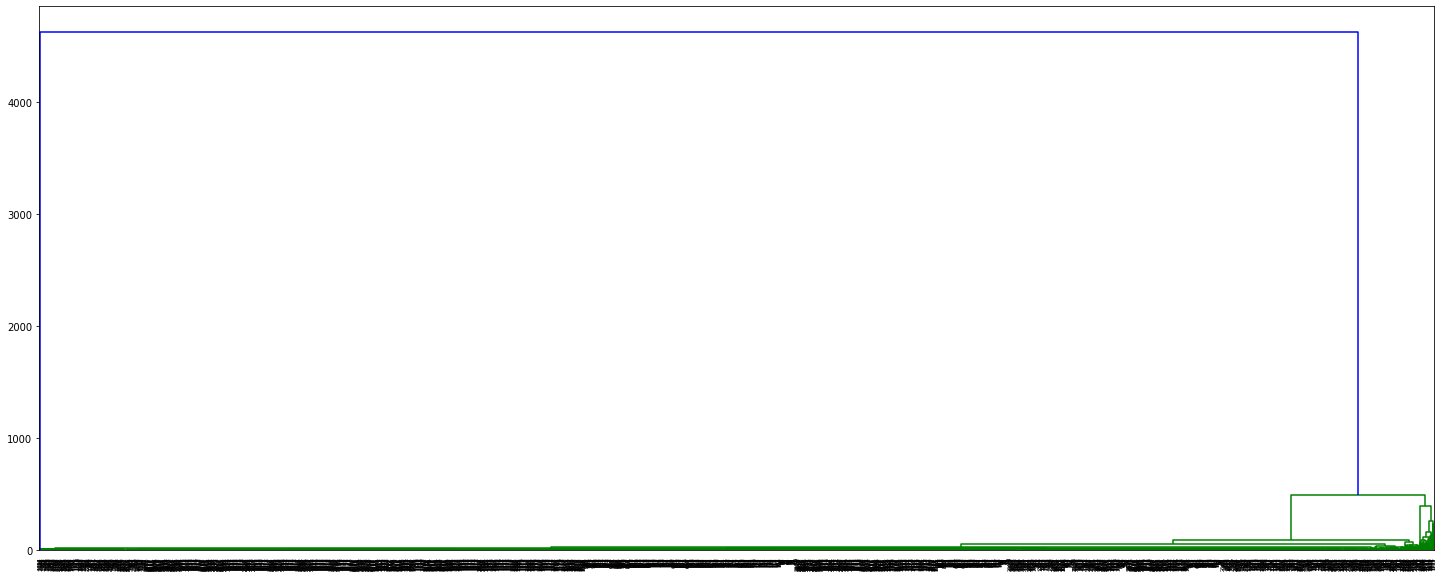

In [27]:
distance_JHU_O = dtw.distance_matrix_fast([np.array(a) for a in JHU_daily_death],compact=True)
Z_JHU_O = linkage(distance_JHU_O, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU_O = dendrogram(Z_JHU_O)


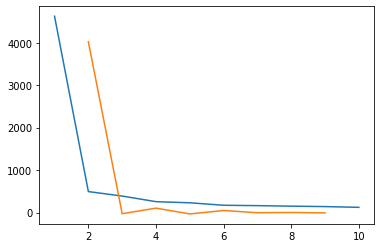

clusters: 2


In [28]:
last = Z_JHU_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [29]:
clusters_JHU_O = fcluster(Z_JHU_O, 2, criterion='maxclust')

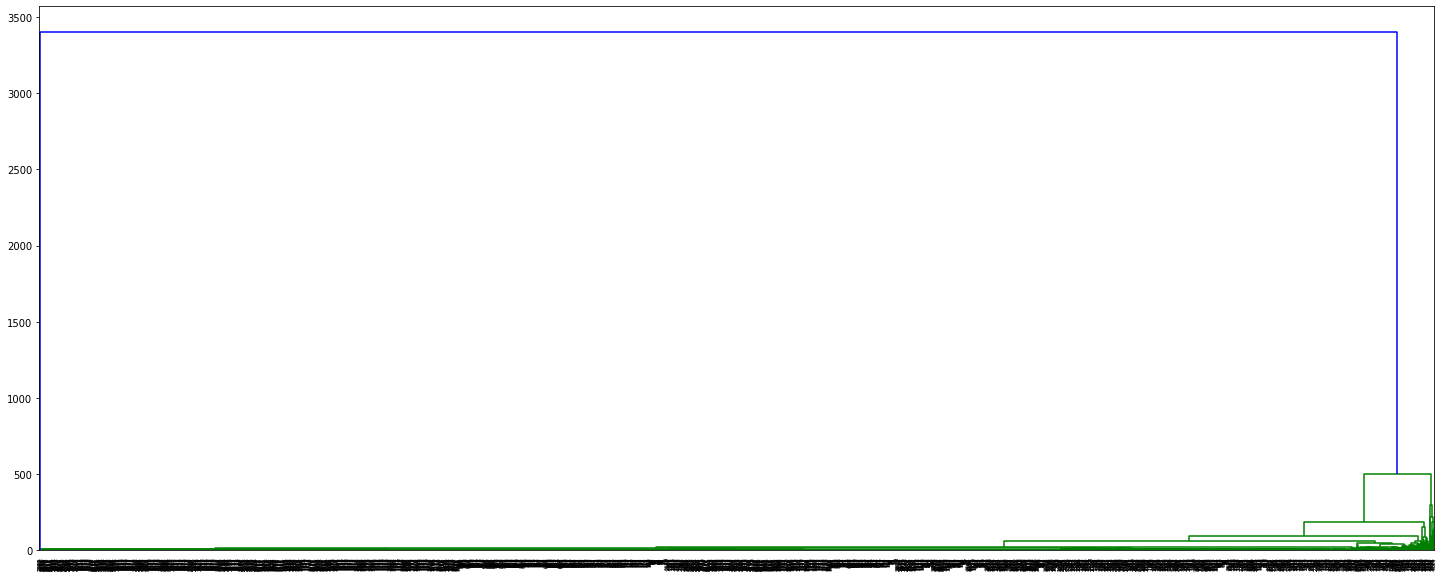

In [30]:
distance_NYT_F_O = dtw.distance_matrix_fast([np.array(a) for a in NYT_daily_Death_Filled],compact=True)
Z_NYT_F_O = linkage(distance_NYT_F_O, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F_O = dendrogram(Z_NYT_F_O)

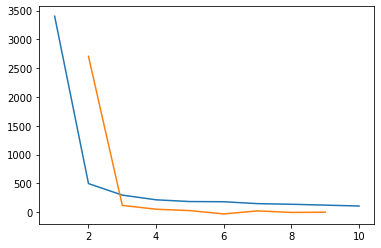

clusters: 2


In [31]:
last = Z_NYT_F_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [32]:
clusters_NYT_F_O = fcluster(Z_NYT_F_O, 2, criterion='maxclust')

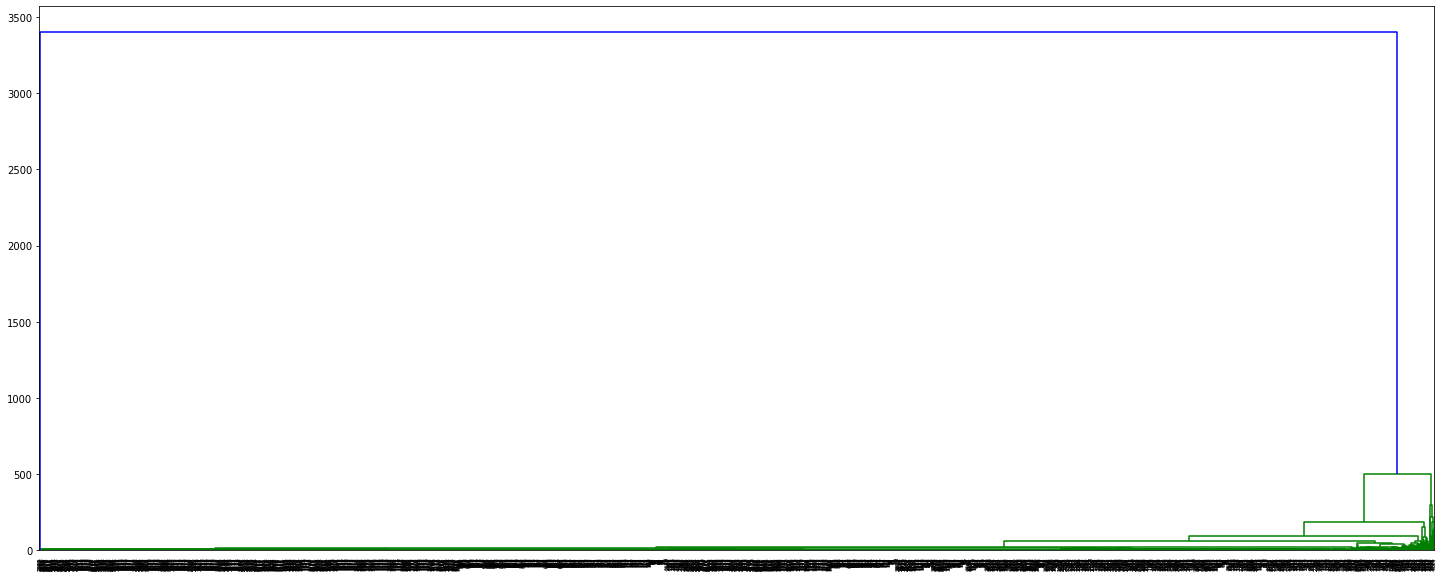

In [33]:
distance_NYT_W_O = dtw.distance_matrix_fast([np.array(a) for a in NYT_daily_Warp_Death],compact=True)
Z_NYT_W_O = linkage(distance_NYT_W_O, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_W_O = dendrogram(Z_NYT_W_O)

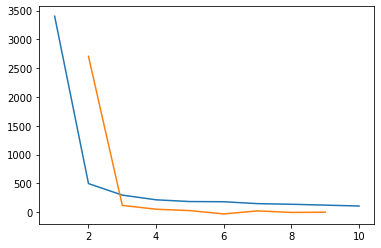

clusters: 2


In [34]:
last = Z_NYT_W_O[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [35]:
clusters_NYT_W_O = fcluster(Z_NYT_W_O, 2, criterion='maxclust')

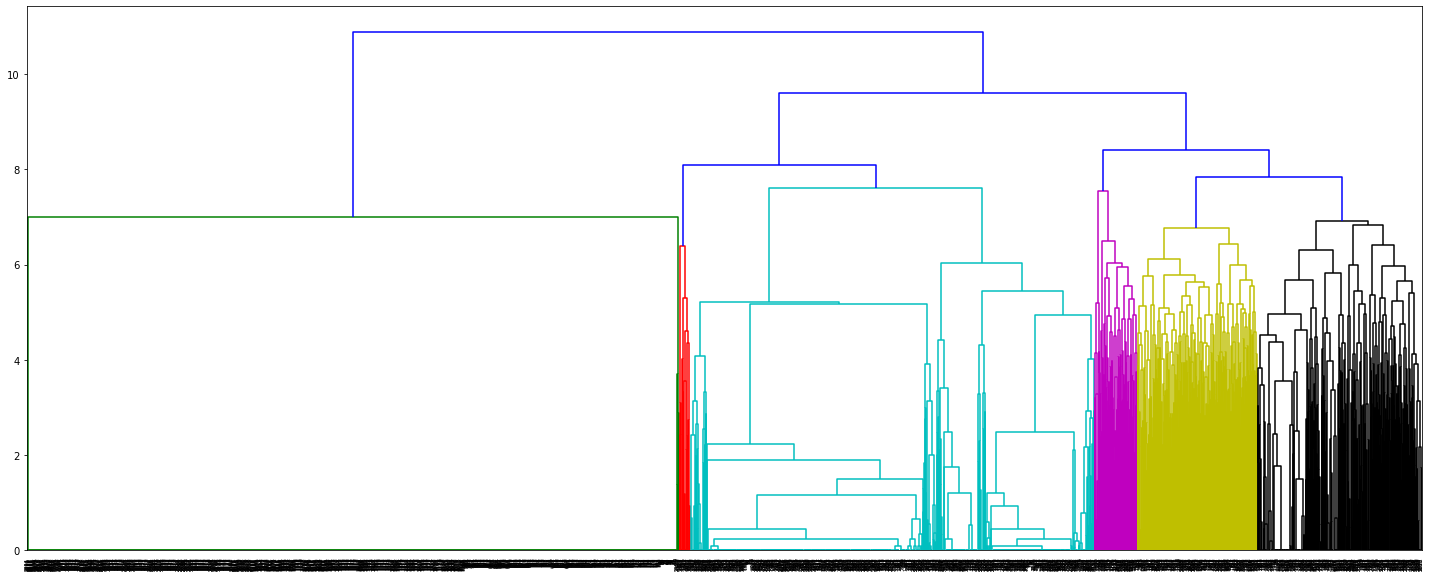

In [36]:
distance_JHU = dtw.distance_matrix_fast(Series_JHU,compact=True)
Z_JHU = linkage(distance_JHU,method='complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU = dendrogram(Z_JHU)


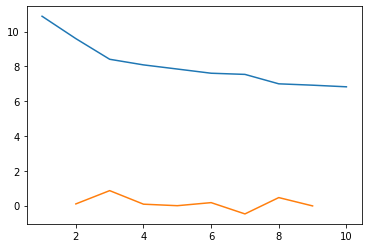

clusters: 3


In [37]:
last = Z_JHU[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [38]:
clusters_JHU = fcluster(Z_JHU, 3, criterion='maxclust')

In [39]:
clusters_JHU

array([3, 3, 2, ..., 1, 1, 1], dtype=int32)

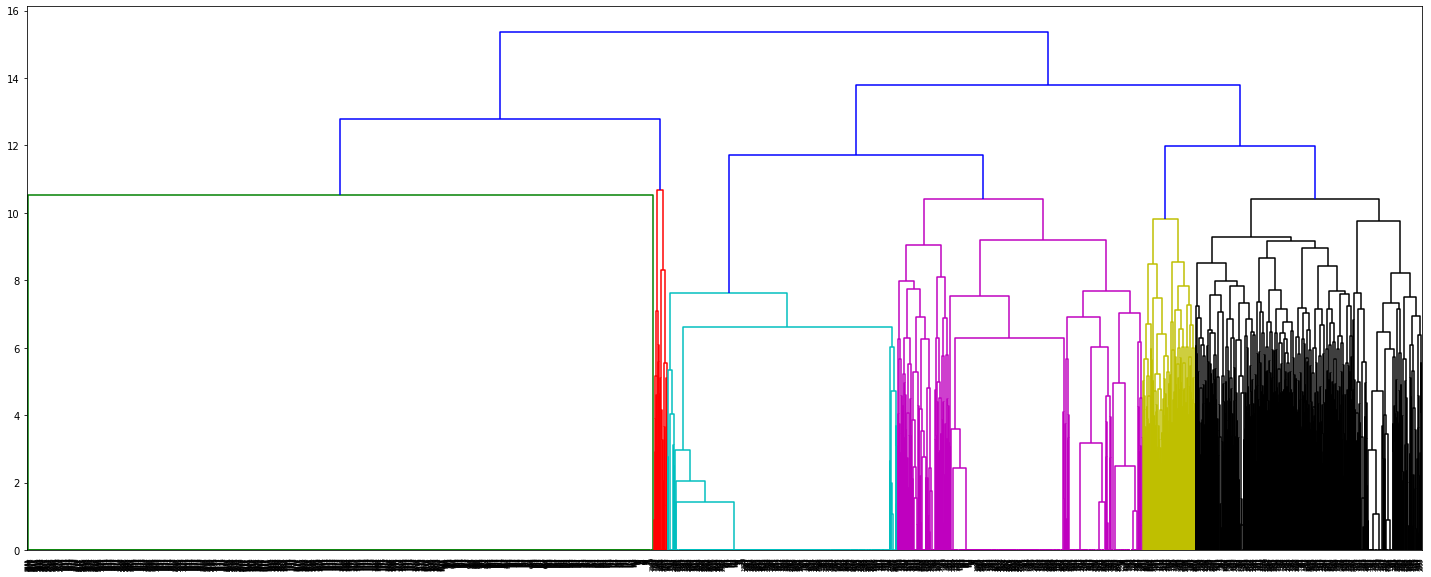

In [40]:
distance_NYT_F = dtw.distance_matrix_fast(Series_NYT_F,compact=True)
Z_NYT_F = linkage(distance_NYT_F, method= 'complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F = dendrogram(Z_NYT_F)

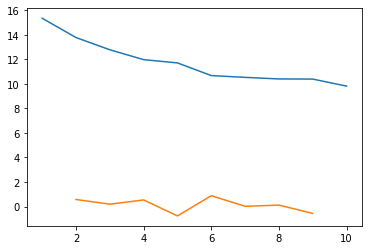

clusters: 6


In [41]:
last = Z_NYT_F[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [42]:
clusters_NYT_F = fcluster(Z_NYT_F, 6, criterion='maxclust')

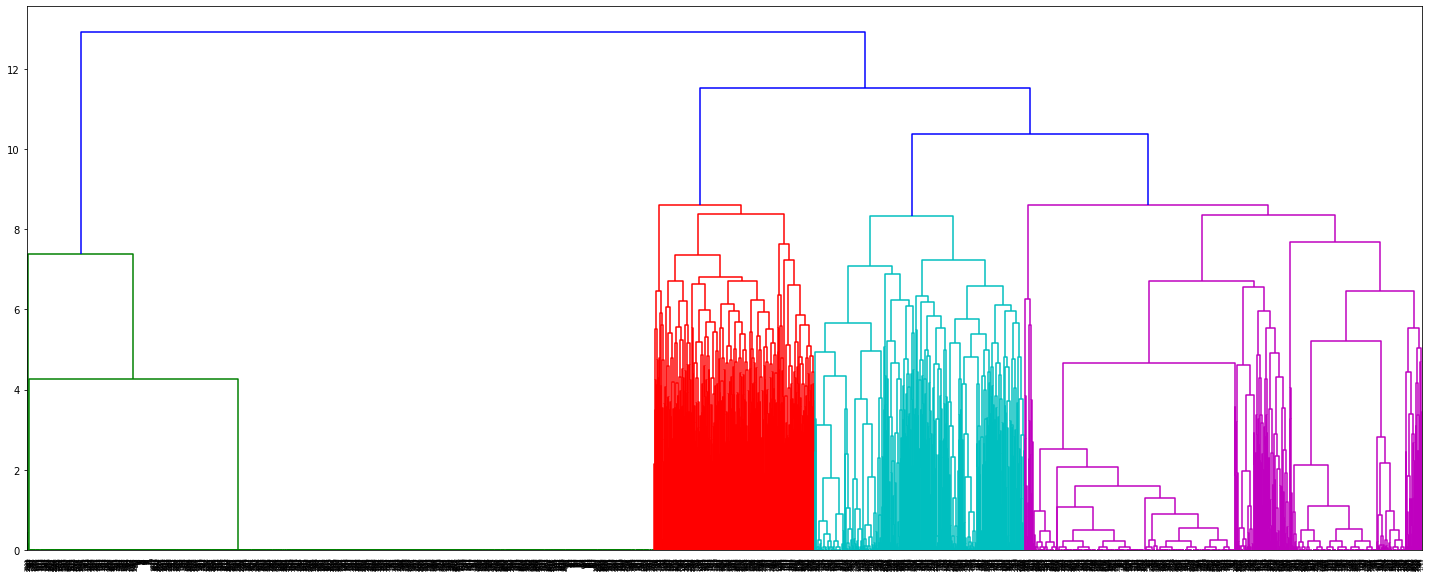

In [43]:
distance_NYT_W = dtw.distance_matrix_fast(Series_NYT_W,compact=True)
Z_NYT_W = linkage(distance_NYT_W, method='complete')
fig = plt.figure(figsize=(25, 10))
dn = dendrogram(Z_NYT_W)

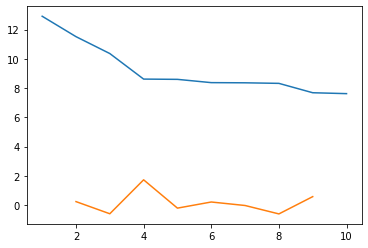

clusters: 4


In [44]:
last = Z_NYT_W[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [45]:
clusters_NYT_W = fcluster(Z_NYT_W, 4, criterion='maxclust')

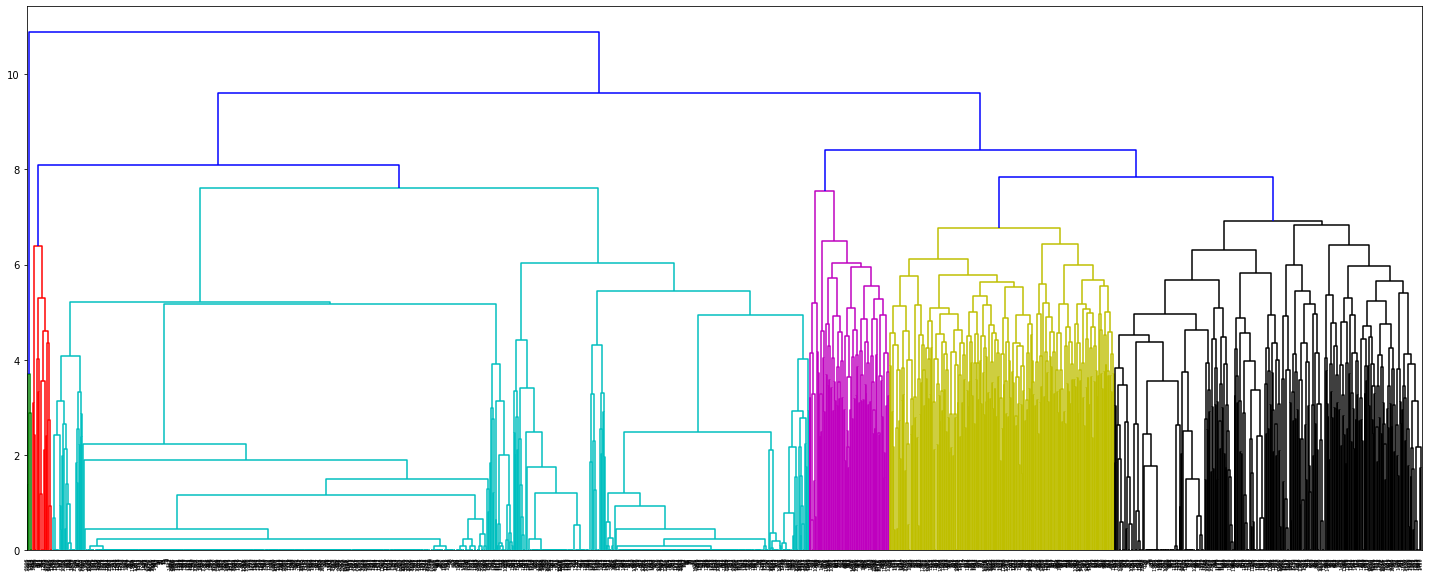

In [46]:
distance_JHU_N = dtw.distance_matrix_fast(Series_JHU_nozeros,compact=True)
Z_JHU_N = linkage(distance_JHU_N, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_JHU_N = dendrogram(Z_JHU_N)

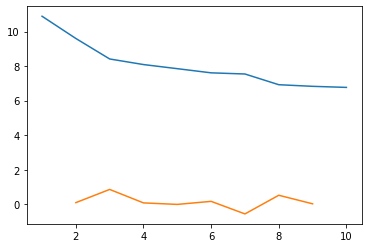

clusters: 3


In [47]:
last = Z_JHU_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [48]:
clusters_JHU_N = fcluster(Z_JHU_N, 3, criterion='maxclust')
temp = []
ind = nonzerofips(Series_JHU)
n = 0
for i in range(len(Series_JHU)):
    if i in ind:
        temp.append(clusters_JHU_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_JHU_N = temp

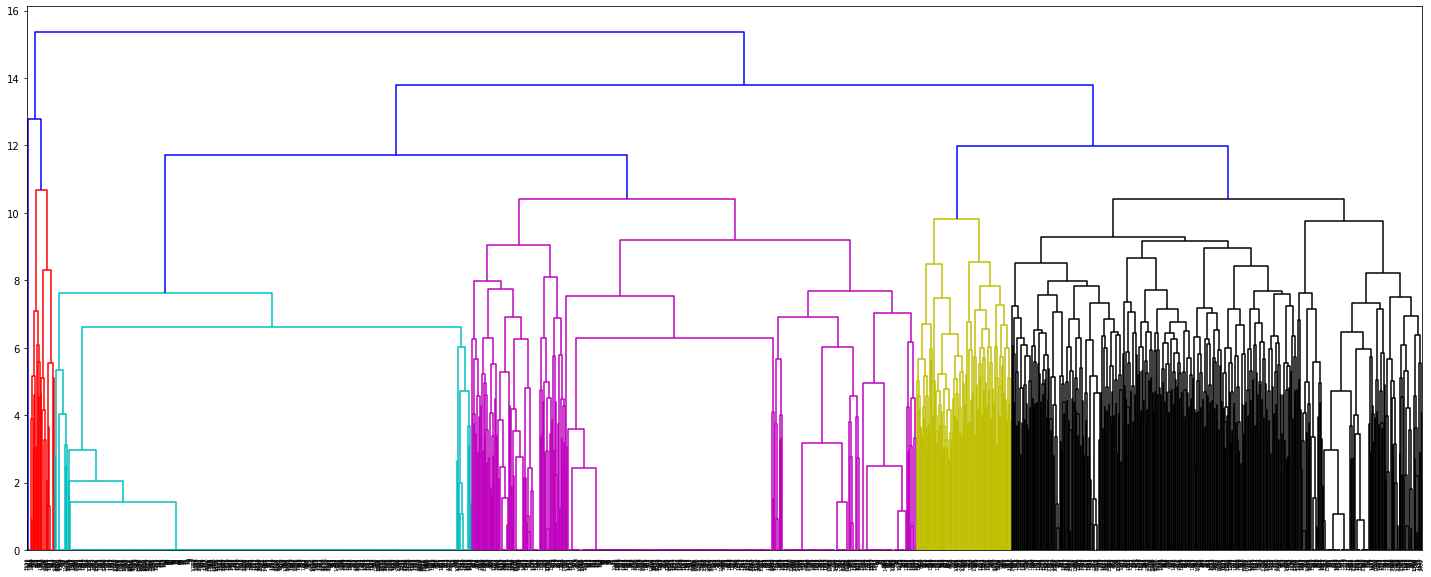

In [49]:
distance_NYT_F_N = dtw.distance_matrix_fast(Series_NYT_F_nozeros,compact=True)
Z_NYT_F_N = linkage(distance_NYT_F_N, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_F_N = dendrogram(Z_NYT_F_N)

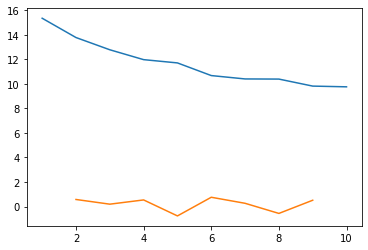

clusters: 6


In [50]:
last = Z_NYT_F_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [51]:
clusters_NYT_F_N = fcluster(Z_NYT_F_N, 6, criterion='maxclust')
temp = []
ind = nonzerofips(Series_NYT_F)
n = 0
for i in range(len(Series_NYT_F)):
    if i in ind:
        temp.append(clusters_NYT_F_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_NYT_F_N = temp

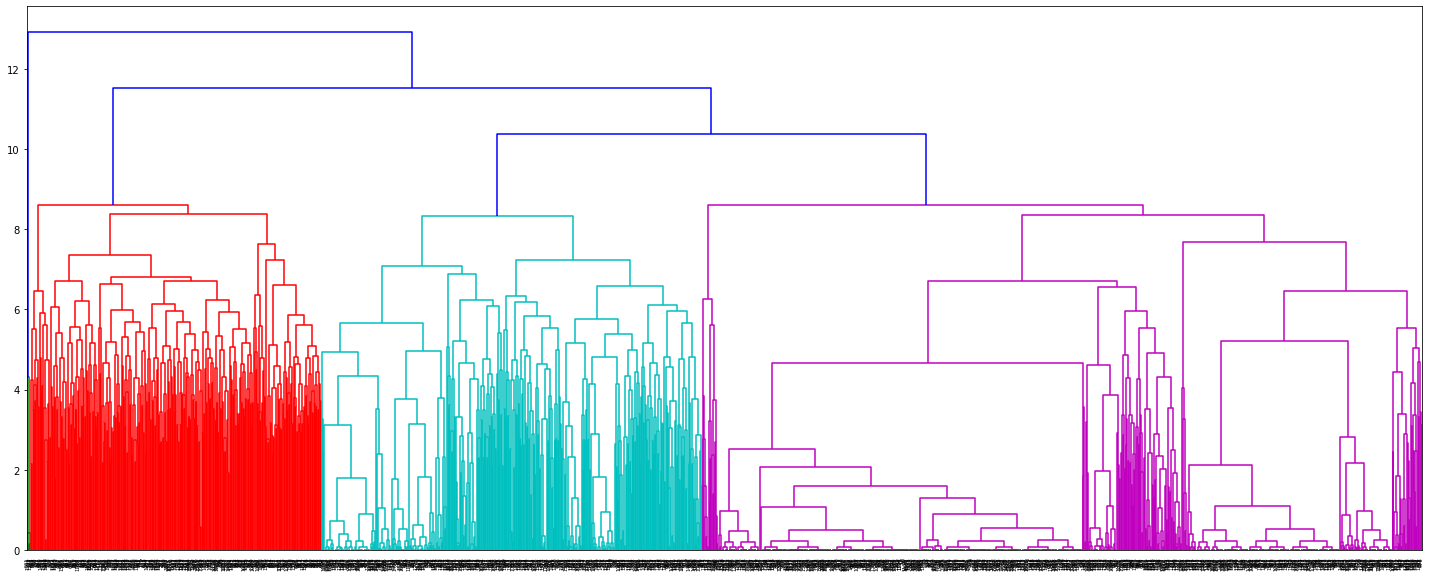

In [52]:
distance_NYT_W_N = dtw.distance_matrix_fast(Series_NYT_W_nozeros,compact=True)
Z_NYT_W_N = linkage(distance_NYT_W_N, method='complete')
fig = plt.figure(figsize=(25, 10))
dn_NYT_W_N = dendrogram(Z_NYT_W_N)

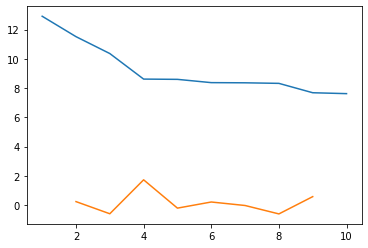

clusters: 4


In [53]:
last = Z_NYT_W_N[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:", k)


In [54]:
clusters_NYT_W_N = fcluster(Z_NYT_W_N, 4, criterion='maxclust')
temp = []
ind = nonzerofips(Series_NYT_W)
n = 0
for i in range(len(Series_NYT_W)):
    if i in ind:
        temp.append(clusters_NYT_W_N[n])
        n += 1
    else:
        temp.append(0)                  
clusters_NYT_W_N = temp

In [55]:
ClustersJHU = pd.DataFrame(data=JHU_daily.FIPS.unique(),columns=['FIPS'])
ClustersJHU['ZClusters'] = clusters_JHU
ClustersJHU['ZNClusters'] = clusters_JHU_N
ClustersJHU['OrigClusters'] = clusters_JHU_O

In [56]:
ClustersNYT_F = pd.DataFrame(data=NYT_daily_Filled.fips.unique(),columns=['FIPS'])
ClustersNYT_F['ZClusters_F'] = clusters_NYT_F
ClustersNYT_F['ZNClusters_F'] = clusters_NYT_F_N
ClustersNYT_F['OrigClusters_F'] = clusters_NYT_F_O

In [57]:
ClustersNYT_W = pd.DataFrame(data=NYT_daily_Warp.fips.unique(),columns=['FIPS'])
ClustersNYT_W['ZClusters_W'] = clusters_NYT_W
ClustersNYT_W['ZNClusters_W'] = clusters_NYT_W_N
ClustersNYT_W['OrigClusters_W'] = clusters_NYT_W_O

In [58]:
AllClusters = ClustersJHU.join(ClustersNYT_F.set_index('FIPS'), on='FIPS', \
                               how='outer').join(ClustersNYT_W.set_index('FIPS'), on='FIPS', how='outer').sort_values('FIPS')

In [76]:
AllClusters[AllClusters['ZClusters_F']==5]

,FIPS,ZClusters,ZNClusters,OrigClusters,ZClusters_F,ZNClusters_F,OrigClusters_F,ZClusters_W,ZNClusters_W,OrigClusters_W
48,1097.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
50,1101.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
88,4013.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
89,4015.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
186,6037.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
196,6059.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
240,8031.0,3.0,3.0,1.0,5.0,5.0,1.0,3.0,3.0,1.0
284,9001.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
285,9003.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0
287,9007.0,3.0,3.0,1.0,5.0,5.0,1.0,2.0,2.0,1.0


In [85]:
NYT_daily_Filled[NYT_daily_Filled['fips'] == 9001].head(200)

,fips,date,id,cases,deaths
31635,9001,2020-01-21,"9001, 2020-01-21",0.0,0.0
31636,9001,2020-01-22,"9001, 2020-01-22",0.0,0.0
31637,9001,2020-01-23,"9001, 2020-01-23",0.0,0.0
31638,9001,2020-01-24,"9001, 2020-01-24",0.0,0.0
31639,9001,2020-01-25,"9001, 2020-01-25",0.0,0.0
31640,9001,2020-01-26,"9001, 2020-01-26",0.0,0.0
31641,9001,2020-01-27,"9001, 2020-01-27",0.0,0.0
31642,9001,2020-01-28,"9001, 2020-01-28",0.0,0.0
31643,9001,2020-01-29,"9001, 2020-01-29",0.0,0.0
31644,9001,2020-01-30,"9001, 2020-01-30",0.0,0.0


In [ ]:
SupHMM = []
Maplist = []
for i in sorted(AllClusters.ZClusters_F.dropna().unique()):
    print(i)
    fips = list(AllClusters[AllClusters['ZNClusters_F'] == i]['FIPS'])
    Rows = JHU_daily[JHU_daily['FIPS'].isin(fips)]
    UnSup = makeHMMUnSupData(Rows, 'Deaths', 'FIPS')
    [Map, RMap, UnSupHMM] = makeHMMmap(UnSup)
    Sup = makeHMMSupData(UnSupHMM)
    SupHMM.append(supervised_HMM(Sup[0],Sup[1]))
    Maplist.append(Map)


In [109]:
test = np.zeros(14)
for i in range(6):
    for j in range(10000):
        test += np.array(sample_sentence(SupHMM[i], Maplist[i], 14, 1))
    print(test/10000)
    print(Maplist[i])


[0.     0.0056 0.007  0.006  0.0046 0.006  0.0058 0.0054 0.0066 0.0059
 0.0054 0.0047 0.0069 0.006 ]
{0: 0, 1: 1, 3: 2}
[0.3316 0.2016 0.1724 0.174  0.1725 0.1738 0.1809 0.1723 0.1768 0.1791
 0.1658 0.1805 0.1813 0.1862]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}
[0.4373 0.2363 0.201  0.2077 0.1949 0.2066 0.2126 0.2028 0.2157 0.2096
 0.1956 0.2114 0.2115 0.2163]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 16: 8}
[0.6783 0.3896 0.3504 0.3706 0.3702 0.3781 0.376  0.3648 0.3587 0.3551
 0.3456 0.3962 0.3868 0.3949]
{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 15: 14, 16: 15, 17: 16, 18: 17, 19: 18, 20: 19, 21: 20, 22: 21, 23: 22, 24: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 32: 29, 33: 30, 34: 31, 38: 32, 39: 33, 40: 34, 44: 35, 45: 36, 48: 37, 49: 38, 50: 39, 51: 40, 52: 41, 60: 42, 64: 43, 166: 44, 226: 45}
[2.2942 4.0244 5.5059 5.6409 7.1616 7.9488 7.9395 8.1643 8.6511 8.596
 8.6713 9.8568 9.323  9.0229]
{0: 0, 1: 1, 2: 2, 3: 3, 4:

In [110]:
DailyCaseUnSup = makeHMMUnSupData(NYT_daily, 'cases', 'fips')
DailyDeathUnSup = makeHMMUnSupData(NYT_daily, 'deaths', 'fips')

TotalCaseUnSup = makeHMMUnSupData(NYT_tot, 'cases', 'fips')
TotalDeathUnSup = makeHMMUnSupData(NYT_tot, 'deaths', 'fips')
TotalRateUnSup = makeHMMUnSupData(NYT_tot, 'deathstate', 'fips')

In [84]:
[DailyCaseMap, DailyCaseRMap, DailyCaseUnSupHMM] = makeHMMmap(DailyCaseUnSup)
[DailyDeathMap, DailyDeathRMap, DailyDeathUnSupHMM] = makeHMMmap(DailyDeathUnSup)

[TotalCaseMap, TotalCaseRMap, TotalCaseUnSupHMM] = makeHMMmap(TotalCaseUnSup)
[TotalDeathMap, TotalDeathRMap, TotalDeathUnSupHMM] = makeHMMmap(TotalDeathUnSup)
[TotalRateMap, TotalRateRMap, TotalRateUnSupHMM] = makeHMMmap(TotalRateUnSup)

In [85]:
DailyCaseSup = makeHMMSupData(DailyCaseUnSupHMM)
DailyDeathSup = makeHMMSupData(DailyDeathUnSupHMM)

TotalCaseSup = makeHMMSupData(TotalCaseUnSupHMM)
TotalDeathSup = makeHMMSupData(TotalDeathUnSupHMM)
TotalRateSup = makeHMMSupData(TotalRateUnSupHMM)

In [96]:
DailyDeathMap

{0.0: 0,
 1.0: 1,
 2.0: 2,
 3.0: 3,
 4.0: 4,
 5.0: 5,
 6.0: 6,
 7.0: 7,
 8.0: 8,
 9.0: 9,
 10.0: 10,
 11.0: 11,
 12.0: 12,
 13.0: 13,
 14.0: 14,
 15.0: 15,
 16.0: 16,
 17.0: 17,
 18.0: 18,
 19.0: 19,
 20.0: 20,
 21.0: 21,
 22.0: 22,
 23.0: 23,
 24.0: 24,
 25.0: 25,
 26.0: 26,
 27.0: 27,
 28.0: 28,
 29.0: 29,
 30.0: 30,
 31.0: 31,
 32.0: 32,
 33.0: 33,
 34.0: 34,
 35.0: 35,
 36.0: 36,
 37.0: 37,
 38.0: 38,
 39.0: 39,
 40.0: 40,
 41.0: 41,
 42.0: 42,
 43.0: 43,
 44.0: 44,
 45.0: 45,
 46.0: 46,
 47.0: 47,
 48.0: 48,
 49.0: 49,
 50.0: 50,
 51.0: 51,
 52.0: 52,
 53.0: 53,
 54.0: 54,
 55.0: 55,
 56.0: 56,
 57.0: 57,
 58.0: 58,
 59.0: 59,
 60.0: 60,
 61.0: 61,
 62.0: 62,
 63.0: 63,
 64.0: 64,
 65.0: 65,
 66.0: 66,
 67.0: 67,
 68.0: 68,
 69.0: 69,
 70.0: 70,
 71.0: 71,
 74.0: 72,
 75.0: 73,
 77.0: 74,
 78.0: 75,
 79.0: 76,
 80.0: 77,
 81.0: 78,
 82.0: 79,
 85.0: 80,
 87.0: 81,
 88.0: 82,
 91.0: 83,
 92.0: 84,
 93.0: 85,
 97.0: 86,
 98.0: 87,
 100.0: 88,
 102.0: 89,
 104.0: 90,
 105.0: 91,
 108